In [1]:
import json
import os

import tqdm
import datetime
import pytz
import numpy

import pandas

%matplotlib widget
import matplotlib
import matplotlib.pyplot

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
root_path = '/Users/matthieu/Documents/proto3/blumau_experiments_processing/data/' + source_computer + '/' # To be changed
data_path = root_path + 'metadata/'
conf_path = root_path + 'config/'

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
print(pfiles)

['all_waggles.pickle', 'metadata_waggles20230714.pickle', 'metadata_waggles20230715.pickle', 'metadata_waggles20230716.pickle', 'metadata_waggles20230717.pickle', 'metadata_waggles20230718.pickle', 'metadata_waggles20230719.pickle', 'metadata_waggles20230720.pickle', 'metadata_waggles20230721.pickle', 'metadata_waggles20230722.pickle', 'metadata_waggles20230723.pickle', 'metadata_waggles20230724.pickle', 'metadata_waggles20230725.pickle', 'metadata_waggles20230726.pickle', 'metadata_waggles20230727.pickle', 'metadata_waggles20230728.pickle', 'metadata_waggles20230729.pickle', 'metadata_waggles20230730.pickle', 'metadata_waggles20230731.pickle']


# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, data_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(data_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]
all_waggles_df.head(5)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
0,18434927546356664479,205,-1.143186,4.589325,0.788175,2,2023-07-14 16:45:07.475806+00:00,2023-07-14 16:45:08.125847+00:00,1550.0,944.0,...,1550.0,960.0,2023-07-14,0.650041,-3.348960,-6.062942,-0.330431,-347.381006,-18.932303,True
1,17207792881295891939,205,-2.244534,4.589325,0.862588,2,2023-07-14 16:45:02.158845+00:00,2023-07-14 16:45:02.775513+00:00,1586.0,960.0,...,1606.0,976.0,2023-07-14,0.616668,-3.348695,-7.164026,-0.330166,-410.468442,-18.917145,True
2,10734887546593850369,206,2.796986,2.929605,0.573601,2,2023-07-14 16:45:23.210104+00:00,2023-07-14 16:45:23.676807+00:00,1454.0,992.0,...,1446.0,1000.0,2023-07-14,0.466703,-3.349742,-2.123553,-1.990934,-121.670631,-114.072113,True
3,10228066394540439103,206,-3.097191,2.924824,0.752396,2,2023-07-14 16:45:27.126987+00:00,2023-07-14 16:45:27.293644+00:00,1446.0,1136.0,...,1446.0,1136.0,2023-07-14,0.166657,-3.349937,-8.017924,-1.995910,-459.393219,-114.357214,True
4,10436701760110499376,205,-1.186604,4.775544,0.751323,2,2023-07-14 16:45:09.292561+00:00,2023-07-14 16:45:09.575921+00:00,1526.0,944.0,...,1510.0,960.0,2023-07-14,0.283360,-3.349050,-6.106450,-0.144302,-349.873829,-8.267896,True


# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

exp_configs = pandas.DataFrame.from_records(exp_configs).tail(-1) # remove first row --> default configuration

In [5]:
# # load output bridge data
# wdd_log_file = conf_path+'wdd_bridge_output.txt'
# bridge_lines = []
# corrupted_lines = 0
# with open(wdd_log_file, "r") as f:
#     for line in f:
#         try :
#             data = json.loads(line)
#         except :
#             corrupted_lines += 1
#         data["UTC_timestamp"] = pytz.UTC.localize(datetime.datetime.fromisoformat(data["log_timestamp"]))
#         bridge_lines.append(data)
# print("Output contained {} corrupted lines".format(corrupted_lines))
# bridge_output = pandas.DataFrame.from_dict(bridge_lines)

## Effect of the vibrations on the number of waggle runs

In [6]:
DURATION_EXPERIMENT = datetime.timedelta(minutes=15.0)

results = []

for exp_i, exp in exp_configs.iterrows():
    # print(exp)
    res = dict(exp)

    if exp.rule == 'vibrate':
        res['type'] = 'exp'
        ctrl_start_time = exp['dtts_start'] - DURATION_EXPERIMENT
        ctrl_stop_time  = exp['dtts_start']
        vibs_start_time = exp['dtts_start']
        vibs_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT
    else:
        res['type'] = 'blank'
        ctrl_start_time = exp['dtts_start'] 
        ctrl_stop_time  = exp['dtts_start'] + DURATION_EXPERIMENT
        vibs_start_time = exp['dtts_start'] + DURATION_EXPERIMENT
        vibs_stop_time  = exp['dtts_start'] + 2*DURATION_EXPERIMENT
    

    # Naively take all of the waggles and count them
    ctrl_runs = all_waggles_df[all_waggles_df.timestamp_begin > ctrl_start_time]
    ctrl_runs = ctrl_runs[ctrl_runs.timestamp_begin < ctrl_stop_time]
    vibs_runs = all_waggles_df[all_waggles_df.timestamp_begin > vibs_start_time]
    vibs_runs = vibs_runs[vibs_runs.timestamp_begin < vibs_stop_time]

    res['Ncount_ctrl'] = len(ctrl_runs)
    res['Ncount_vibs'] = len(vibs_runs)
    
    # Take only the waggles with high confidence and count them
    ctrl_runs_confidence = ctrl_runs[ctrl_runs.label_confidence > 0.99]
    vibs_runs_confidence = vibs_runs[vibs_runs.label_confidence > 0.99]

    res['Ccount_ctrl'] = len(ctrl_runs_confidence)
    res['Ccount_vibs'] = len(vibs_runs_confidence)

    # Compare waggle runs that we want to inhibit with others
    target_angle            = exp.angle_deg
    ctrl_runs_not_targeted  = ctrl_runs_confidence[abs(ctrl_runs_confidence.world_angle_deg%360-target_angle) > 90]
    ctrl_runs_targeted      = ctrl_runs_confidence[abs(ctrl_runs_confidence.world_angle_deg%360-target_angle) < 90]
    vibs_runs_not_targeted  = vibs_runs_confidence[abs(vibs_runs_confidence.world_angle_deg%360-target_angle) > 90]
    vibs_runs_targeted      = vibs_runs_confidence[abs(vibs_runs_confidence.world_angle_deg%360-target_angle) < 90]

    res['Tcount_ctrl']  = len(ctrl_runs_targeted)
    res['NTcount_ctrl'] = len(ctrl_runs_not_targeted)
    res['Tcount_vibs']  = len(vibs_runs_targeted)
    res['NTcount_vibs'] = len(vibs_runs_not_targeted)

    results.append(res)

results         = pandas.DataFrame.from_dict(results)
exp_results     = results[results.type == 'exp']
blank_results   = results[results.type == 'blank']

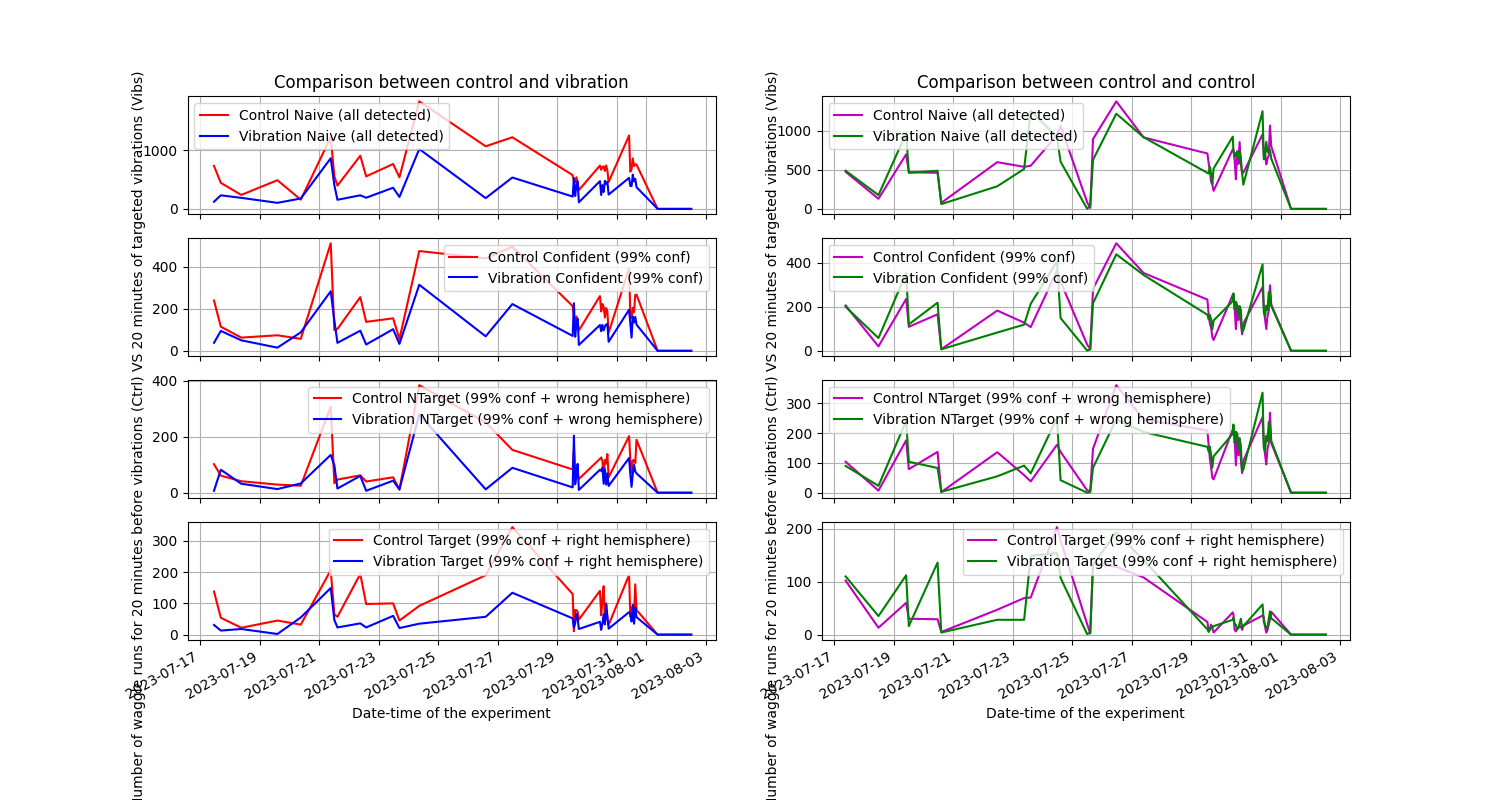

In [7]:
N_plots_h = 2
N_plots_v = 4
fig, ax = matplotlib.pyplot.subplots(N_plots_v, N_plots_h, figsize=(15,8), sharex=True)
ax[0,0].plot(exp_results.dtts_start, exp_results.Ncount_ctrl, c='r', label='Control Naive (all detected)')
ax[0,0].plot(exp_results.dtts_start, exp_results.Ncount_vibs, c='b', label='Vibration Naive (all detected)')

ax[1,0].plot(exp_results.dtts_start, exp_results.Ccount_ctrl, c='r', label='Control Confident (99% conf)')
ax[1,0].plot(exp_results.dtts_start, exp_results.Ccount_vibs, c='b', label='Vibration Confident (99% conf)')

ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_ctrl, c='r', label='Control NTarget (99% conf + wrong hemisphere)')
ax[2,0].plot(exp_results.dtts_start, exp_results.NTcount_vibs, c='b', label='Vibration NTarget (99% conf + wrong hemisphere)')

ax[3,0].plot(exp_results.dtts_start, exp_results.Tcount_ctrl, c='r', label='Control Target (99% conf + right hemisphere)')
ax[3,0].plot(exp_results.dtts_start, exp_results.Tcount_vibs, c='b', label='Vibration Target (99% conf + right hemisphere)')


ax[0,1].plot(blank_results.dtts_start, blank_results.Ncount_ctrl, c='m', label='Control Naive (all detected)')
ax[0,1].plot(blank_results.dtts_start, blank_results.Ncount_vibs, c='g', label='Vibration Naive (all detected)')

ax[1,1].plot(blank_results.dtts_start, blank_results.Ccount_ctrl, c='m', label='Control Confident (99% conf)')
ax[1,1].plot(blank_results.dtts_start, blank_results.Ccount_vibs, c='g', label='Vibration Confident (99% conf)')

ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_ctrl, c='m', label='Control NTarget (99% conf + wrong hemisphere)')
ax[2,1].plot(blank_results.dtts_start, blank_results.NTcount_vibs, c='g', label='Vibration NTarget (99% conf + wrong hemisphere)')

ax[3,1].plot(blank_results.dtts_start, blank_results.Tcount_ctrl, c='m', label='Control Target (99% conf + right hemisphere)')
ax[3,1].plot(blank_results.dtts_start, blank_results.Tcount_vibs, c='g', label='Vibration Target (99% conf + right hemisphere)')

for i in range(N_plots_v):
    for j in range(N_plots_h):
        ax[i,j].grid()
        ax[i,j].legend()

_ = ax[0,0].set_title('Comparison between control and vibration')
_ = ax[2,0].set_ylabel('Number of waggle runs for 20 minutes before vibrations (Ctrl) VS 20 minutes of targeted vibrations (Vibs)')
_ = ax[3,0].set_xlabel('Date-time of the experiment')

_ = ax[0,1].set_title('Comparison between control and control')
_ = ax[2,1].set_ylabel('Number of waggle runs for 20 minutes before vibrations (Ctrl) VS 20 minutes of targeted vibrations (Vibs)')
_ = ax[3,1].set_xlabel('Date-time of the experiment')

matplotlib.pyplot.gcf().autofmt_xdate()

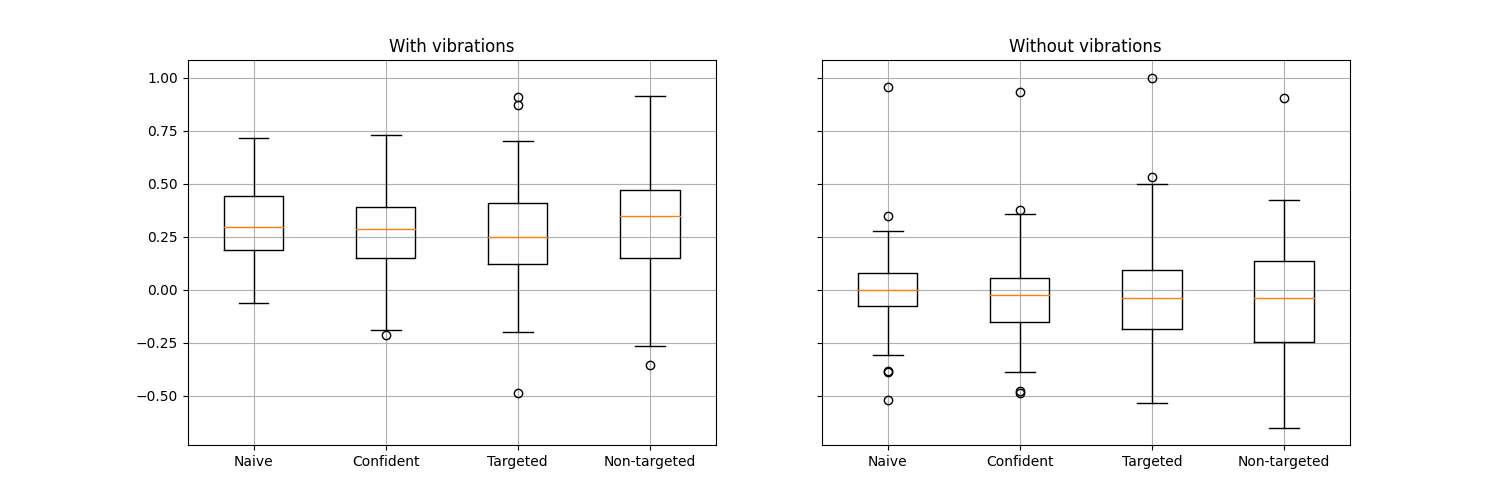

In [8]:
N_drop_exp  = (exp_results.Ncount_ctrl-exp_results.Ncount_vibs)/(exp_results.Ncount_ctrl+exp_results.Ncount_vibs)
C_drop_exp  = (exp_results.Ccount_ctrl-exp_results.Ccount_vibs)/(exp_results.Ccount_ctrl+exp_results.Ccount_vibs)
NT_drop_exp = (exp_results.NTcount_ctrl-exp_results.NTcount_vibs)/(exp_results.NTcount_ctrl+exp_results.NTcount_vibs)
T_drop_exp  = (exp_results.Tcount_ctrl-exp_results.Tcount_vibs)/(exp_results.Tcount_ctrl+exp_results.Tcount_vibs)

N_drop_exp_nanfree  = N_drop_exp.values[~numpy.isnan(N_drop_exp.values)]
C_drop_exp_nanfree  = C_drop_exp.values[~numpy.isnan(C_drop_exp.values)]
NT_drop_exp_nanfree = NT_drop_exp.values[~numpy.isnan(NT_drop_exp.values)]
T_drop_exp_nanfree  = T_drop_exp.values[~numpy.isnan(T_drop_exp.values)]

N_drop_blank  = (blank_results.Ncount_ctrl-blank_results.Ncount_vibs)/(blank_results.Ncount_ctrl+blank_results.Ncount_vibs)
C_drop_blank  = (blank_results.Ccount_ctrl-blank_results.Ccount_vibs)/(blank_results.Ccount_ctrl+blank_results.Ccount_vibs)
NT_drop_blank = (blank_results.NTcount_ctrl-blank_results.NTcount_vibs)/(blank_results.NTcount_ctrl+blank_results.NTcount_vibs)
T_drop_blank  = (blank_results.Tcount_ctrl-blank_results.Tcount_vibs)/(blank_results.Tcount_ctrl+blank_results.Tcount_vibs)

N_drop_blank_nanfree  = N_drop_blank.values[~numpy.isnan(N_drop_blank.values)]
C_drop_blank_nanfree  = C_drop_blank.values[~numpy.isnan(C_drop_blank.values)]
NT_drop_blank_nanfree = NT_drop_blank.values[~numpy.isnan(NT_drop_blank.values)]
T_drop_blank_nanfree  = T_drop_blank.values[~numpy.isnan(T_drop_blank.values)]

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(15,5), sharey=True)

ax[0].boxplot([N_drop_exp_nanfree, C_drop_exp_nanfree, NT_drop_exp_nanfree, T_drop_exp_nanfree], labels=['Naive', 'Confident', 'Targeted','Non-targeted'])
ax[0].set_title('With vibrations')
ax[0].grid()

ax[1].boxplot([N_drop_blank_nanfree, C_drop_blank_nanfree, NT_drop_blank_nanfree, T_drop_blank_nanfree], labels=['Naive', 'Confident', 'Targeted','Non-targeted'])
ax[1].set_title('Without vibrations')
ax[1].grid()

In [9]:
import scipy.stats

print("Result of test for targeted waggle runs : {}".format(scipy.stats.ranksums(T_drop_exp_nanfree, T_drop_blank_nanfree)))
print("Result of test for NOT targeted waggle runs : {}".format(scipy.stats.ranksums(NT_drop_exp_nanfree, NT_drop_blank_nanfree)))

Result of test for targeted waggle runs : RanksumsResult(statistic=4.816649066011372, pvalue=1.4598911264841973e-06)
Result of test for NOT targeted waggle runs : RanksumsResult(statistic=4.166453457748498, pvalue=3.093750195912578e-05)


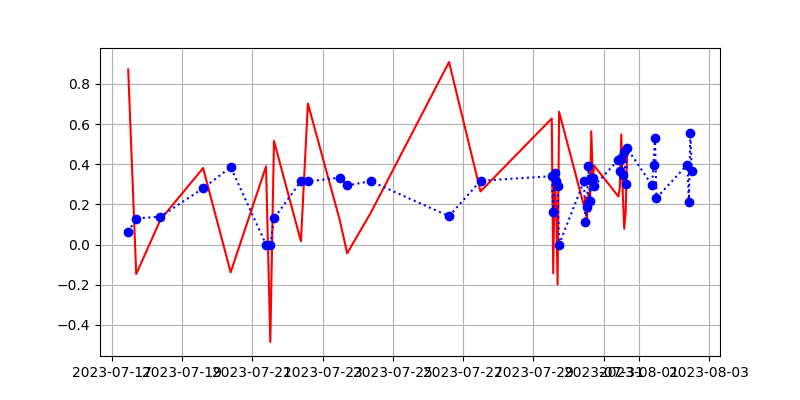

In [11]:
vibrations_periods_infos = pandas.read_pickle(data_path+'processed_actuation_phases.pickle')

fig = matplotlib.pyplot.figure(figsize=(8,4))
matplotlib.pyplot.plot(exp_results.dtts_start, NT_drop_exp, 'r')
# matplotlib.pyplot.plot(exp_results.dtts_start, T_drop_exp, 'g')
matplotlib.pyplot.plot(vibrations_periods_infos['ts_start'], vibrations_periods_infos['ratio'],':ob')
matplotlib.pyplot.grid()

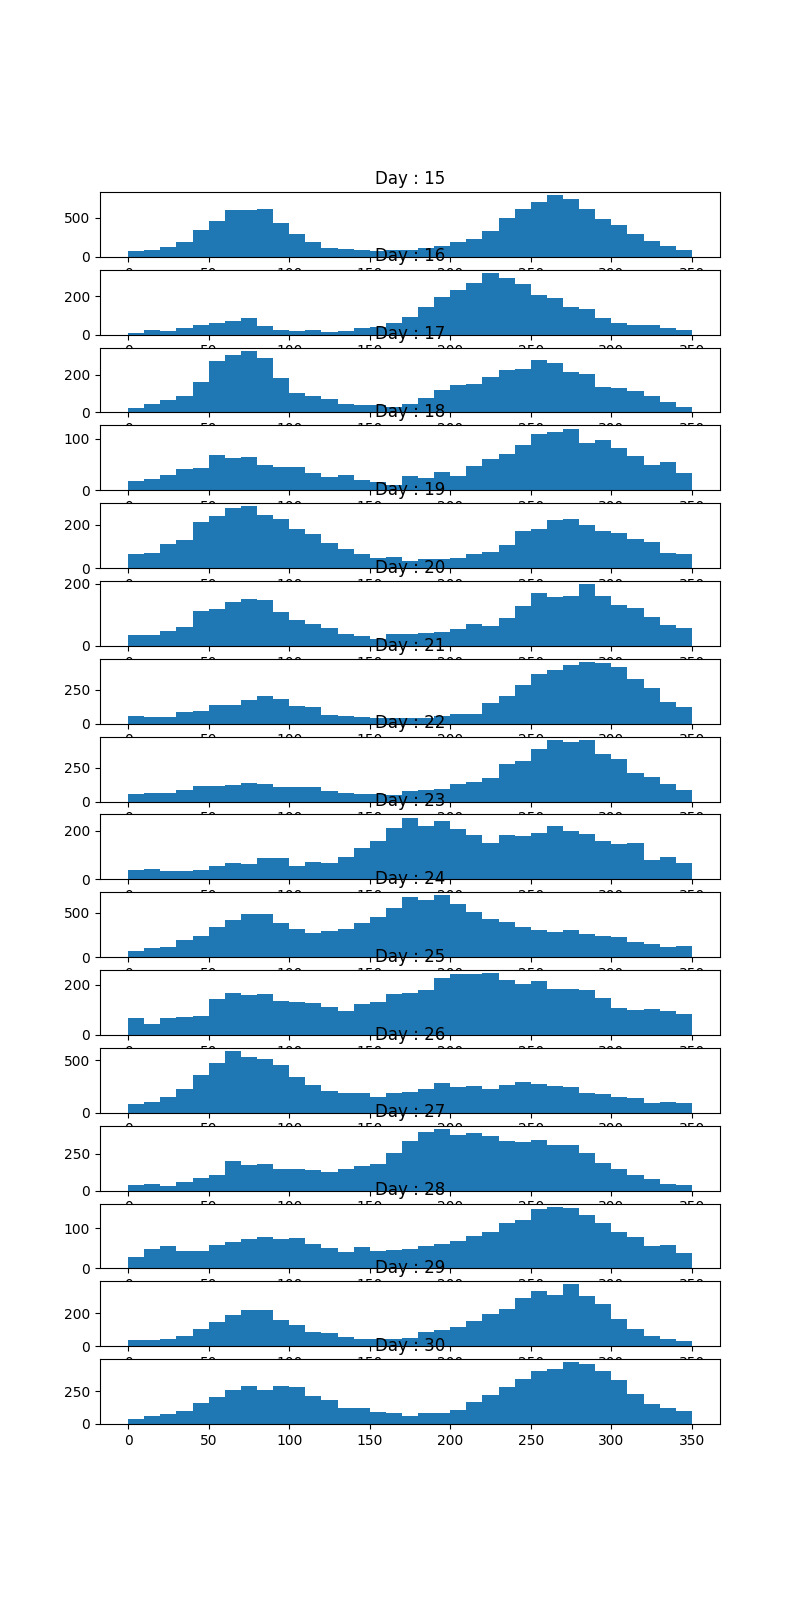

In [12]:
# subplots for day-by-day trend
boundary_day = 16

all_confident = all_waggles_df[all_waggles_df.label_confidence>0.99]
all_confident_1feeder = all_confident[all_confident.timestamp_begin < pytz.utc.localize(datetime.datetime(2023, 7, boundary_day, 1, 0, 0))]
all_confident_2feeder = all_confident[all_confident.timestamp_begin > pytz.utc.localize(datetime.datetime(2023, 7, boundary_day, 1, 0, 0))]

# matplotlib.pyplot.figure()
# matplotlib.pyplot.hist((all_confident_1feeder.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10))#, density=True)
# matplotlib.pyplot.hist((all_confident_2feeder.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10), density=True, alpha=0.5)

fig, ax = matplotlib.pyplot.subplots(16, 1, figsize=(8, 16))
for d in range(15, 31):
    waggles_of_day = all_confident[all_confident.timestamp_begin > pytz.utc.localize(datetime.datetime(2023, 7, d, 1, 0, 0))]
    waggles_of_day = waggles_of_day[waggles_of_day.timestamp_begin < pytz.utc.localize(datetime.datetime(2023, 7, d + 1, 1, 0, 0))]
    ax[d-15].hist((waggles_of_day.world_angle_deg-50)%360, bins=numpy.arange(0, 360, 10))
    ax[d-15].set_title('Day : {}'.format(d))

In [13]:
ctrl_runs_confidence.world_angle_deg

Series([], Name: world_angle_deg, dtype: float64)

In [14]:
all_waggles_df.columns

Index(['waggle_id', 'dance_id', 'waggle_angle', 'dance_angle',
       'waggle_duration', 'cam_id', 'timestamp_begin', 'timestamp_end',
       'wdd_x', 'wdd_y', 'x_median', 'y_median', 'dir_x', 'dir_y', 'label',
       'label_confidence', 'metadata_timestamp', 'dir_index', 'end_x', 'end_y',
       'date', 'timestamp_duration', 'azimuth', 'world_angle',
       'dance_world_angle', 'world_angle_deg', 'dance_world_angle_deg',
       'was_clustered_to_dance'],
      dtype='object')

In [15]:
all_waggles_df.label_confidence.head(5)

0    0.985109
1    0.998502
2    0.976227
3    0.998663
4    0.769049
Name: label_confidence, dtype: float64